# Implementing and Optimizing Meanshift Clustering

This posts includes a cool animation.

Salman Naqvi  
Wednesday, 21 June 2023

> This notebook follows the [fastai style
> guide](https://docs.fast.ai/dev/style.html).

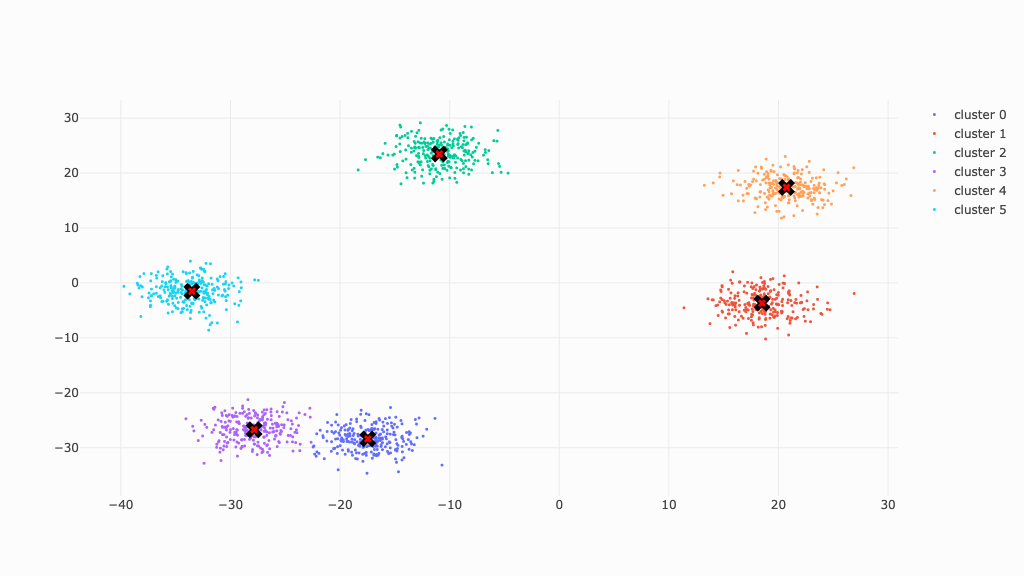

Meanshift clustering is a technique for unsupervised learning. Give this
algorithm a bunch of data and it will figure out what groups the data
can be sorted into. It does this by iteratively moving all data points
until they converge to a single point.

The steps of the algorithm can be summarized as follows:

1.  For each data point $x$ in the dataset, calculate the distance
    between $x$ and every other data point in the dataset.
2.  Calculate weights for each point in the dataset by passing the
    calculated distances through the normal distribution.
3.  Calculate the weighted average for all points in the dataset. This
    weighted average is the new location for $x$

This is the data we will work with to illustrate meanshift clustering.
The data points are put into clearly seperate clusters for the sake of
clarity.

In the end, all clusters will converge at their respective center
(marked by X).

## Implementation

Let’s start of simple and apply the algorithm to a single point.

### Calculate Distances

> For each data point $x$ in the dataset, calculate the distance between
> $x$ and every other data point in the dataset.

In [14]:
data

tensor([[  0.611, -20.199],
        [  4.455, -24.188],
        [  2.071, -20.446],
        ...,
        [ 25.927,   6.597],
        [ 18.549,   3.411],
        [ 24.617,   8.485]])

In [15]:
X = data.clone(); X.shape

torch.Size([1500, 2])

Each point has an $x$ coordinate and a $y$ coordinate.

In [16]:
x = X[0, :]; x - X

tensor([[  0.000,   0.000],
        [ -3.844,   3.989],
        [ -1.460,   0.247],
        ...,
        [-25.316, -26.796],
        [-17.938, -23.610],
        [-24.006, -28.684]])

The distance metric we’ll use is [Euclidean
distance](https://www.mathsisfun.com/algebra/distance-2-points.html)
— also better known as Pythagoras’ theorem.

$$
\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

In [17]:
dists = (x - X).square().sum(dim=1).sqrt(); dists

tensor([ 0.000,  5.540,  1.481,  ..., 36.864, 29.651, 37.404])

### Calculate Weights

> Calculate weights for each point in the dataset by passing the
> calculated distances through the normal distribution.

The [normal
distribution](https://www.mathsisfun.com/data/standard-normal-distribution.html)
is also known as the Gaussian distribution. A distribution is simply a
way to describe how data is spread out — this isn’t applicable in our
case. What is applicable is the shape of this distribution which we will
use to calculate the weights.

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}
$$

In [18]:
def gauss_kernel(x, mean, std):
  return torch.exp(-(x - mean) ** 2 / (2 * std ** 2)) / (std * torch.sqrt(2 * tensor(torch.pi)))

This is how it looks like.

From the shape of this graph, we can see that larger values of $x$ give
smaller values of $y$, which is what we want — longer distances should
have smaller weights meaning they have a smaller effect on the new
position of the point.

We can control the rate at which the weights go to zero by varying
what’s known as the bandwidth, or the standard deviation. The graph
above is generated with a bandwith of 2.5.

The graph below is generated with a bandwidth of 1.

Let’s get our weights now.

In [23]:
gauss_kernel(dists, mean=0, std=2.5)

tensor([    0.160,     0.014,     0.134,  ...,     0.000,     0.000,     0.000])

In [24]:
bw = 2.5
ws = gauss_kernel(x=dists, mean=0, std=bw)

### Move the Point

> Calculate the weighted average for all points in the dataset. This
> weighted average is the new location for $x$

In [25]:
ws.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [26]:
ws[:, None].shape, X.shape

(torch.Size([1500, 1]), torch.Size([1500, 2]))

Below is the formula for [weighted
average](https://www.mathsisfun.com/data/weighted-mean.html).

$$
\frac{\sum wx}{\sum w}
$$

In words, multiply each data point in the set with its corresponding
weight and sum all products. Divide that with the sum of all weights.

In [27]:
ws[:, None] * X, ws[0] * X[0, :]

(tensor([[     0.097,     -3.223],
         [     0.061,     -0.331],
         [     0.277,     -2.738],
         ...,
         [     0.000,      0.000],
         [     0.000,      0.000],
         [     0.000,      0.000]]),
 tensor([ 0.097, -3.223]))

Let’s calculate the weighted average and assign it as the new location
for our point $x$.

In [28]:
x = (ws[:, None] * X).sum(dim=0) / ws.sum(); x

tensor([  1.695, -20.786])

And there you have it! We just moved a single data point.

Let’s do this for all data points and for a single iteration.

In [29]:
for i, x in enumerate(X):
    dist = (x - X).square().sum(dim=1).sqrt()
    ws = gauss_kernel(x=dist, mean=0, std=bw)
    X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

In [30]:
plot_data(centroids+2, X, n_samples)

Let’s encapsulate the algorithm so we can run it for multiple
iterations.

In [31]:
def update(X):
    for i, x in enumerate(X):
      dist = (x - X).square().sum(dim=1).sqrt()
      ws = gauss_kernel(x=dist, mean=0, std=bw)
      X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

def meanshift(data):
   X = data.clone()
   for _ in range(5): update(X)
   return X

In [32]:
plot_data(centroids+2, meanshift(data), n_samples)

All points have converged.

In [33]:
%timeit -n 10 meanshift(data)

1.7 s ± 282 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

The algorithm took roughly 1.5 seconds to run 5 iterations. We’ll
optimize the algorithm further in [Optimized
Implementation](#optimized-implementation).

As we can see below, simply moving the algorithm to the GPU won’t help
— in fact, it becamse a bit slower.

In [34]:
def update(X):
    for i, x in enumerate(X):
      dist = (x - X).square().sum(dim=1).sqrt()
      ws = gauss_kernel(x=dist, mean=0, std=bw)
      X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

def meanshift(data):
   X = data.clone().to('cuda')
   for _ in range(5): update(X)
   return X.detach().cpu()

%timeit -n 10 meanshift(data)

1.67 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

### Animation

Let’s see meanshift clustering happen in real time.

In [39]:
X = data.clone()
fig = plot_data(centroids+2, X, n_samples, display=False)
fig.update_layout(xaxis_range=[-40, 40], yaxis_range=[-40, 40],  updatemenus=[dict(type='buttons', buttons=[
    dict(label='Play', method='animate', args=[None]),
    dict(label='Pause', method='animate', args=[[None], dict(frame_duration=0, frame_redraw='False', mode='immediate', transition_duration=0)])
])])

frames = [go.Frame(data=fig.data)]
for _ in range(5):
    update(X)
    frames.append(go.Frame(data=plot_data(centroids+2, X, n_samples, display=False).data))
fig.frames = frames
fig.show()

## Optimized Implementation

The implementation above is roughly 1.5s which is slow. Let’s perform
the algorithm on multiple data points simulataneously. We’ll then move
the operations onto the GPU.

### Calculate Distances

> For each data point $x$ in the dataset, calculate the distance between
> $x$ and every other data point in the dataset.

In [40]:
X = data.clone(); X.shape

torch.Size([1500, 2])

We’ll begin with a batch size of 8.

In [41]:
bs = 8
x = X[:bs, :]; x

tensor([[  0.611, -20.199],
        [  4.455, -24.188],
        [  2.071, -20.446],
        [  1.011, -23.082],
        [  4.516, -22.281],
        [ -0.149, -22.113],
        [  4.029, -18.819],
        [  2.960, -18.646]])

In [42]:
x.shape, X.shape

(torch.Size([8, 2]), torch.Size([1500, 2]))

In [43]:
x[:, None, :].shape, X[None, ...].shape

(torch.Size([8, 1, 2]), torch.Size([1, 1500, 2]))

In [44]:
x[:, None, :] - X[None, ...]

tensor([[[  0.000,   0.000],
         [ -3.844,   3.989],
         [ -1.460,   0.247],
         ...,
         [-25.316, -26.796],
         [-17.938, -23.610],
         [-24.006, -28.684]],

        [[  3.844,  -3.989],
         [  0.000,   0.000],
         [  2.383,  -3.742],
         ...,
         [-21.472, -30.786],
         [-14.094, -27.599],
         [-20.162, -32.673]],

        [[  1.460,  -0.247],
         [ -2.383,   3.742],
         [  0.000,   0.000],
         ...,
         [-23.856, -27.043],
         [-16.477, -23.857],
         [-22.546, -28.931]],

        ...,

        [[ -0.759,  -1.914],
         [ -4.603,   2.076],
         [ -2.220,  -1.667],
         ...,
         [-26.076, -28.710],
         [-18.697, -25.523],
         [-24.766, -30.598]],

        [[  3.418,   1.380],
         [ -0.426,   5.369],
         [  1.958,   1.627],
         ...,
         [-21.898, -25.417],
         [-14.520, -22.230],
         [-20.588, -27.304]],

        [[  2.349,   1.553],
       

In [45]:
(x[:, None, :] - X[None, ...]).shape

torch.Size([8, 1500, 2])

In [46]:
dists = (x[:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt(); dists, dists.shape

(tensor([[ 0.000,  5.540,  1.481,  ..., 36.864, 29.651, 37.404],
         [ 5.540,  0.000,  4.437,  ..., 37.534, 30.989, 38.394],
         [ 1.481,  4.437,  0.000,  ..., 36.062, 28.994, 36.679],
         ...,
         [ 2.059,  5.050,  2.776,  ..., 38.784, 31.639, 39.364],
         [ 3.686,  5.386,  2.546,  ..., 33.549, 26.552, 34.196],
         [ 2.816,  5.740,  2.007,  ..., 34.128, 27.009, 34.715]]),
 torch.Size([8, 1500]))

### Calculate Weights

> Calculate weights for each point in the dataset by passing the
> calculated distances through the normal distribution.

We can simplify the guassian kernel to a triangular kernel and still
achieve the same results, with less computation.

In [50]:
plot_func(partial(gauss_kernel, mean=0, std=2.5))

In [51]:
def tri_kernel(x, bw): return (-x+bw).clamp_min(0)/bw
plot_func(partial(tri_kernel, bw=8))

In [53]:
%timeit gauss_kernel(dists, mean=0, std=2.5)

311 µs ± 8.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

In [54]:
%timeit tri_kernel(dists, bw=8)

25 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

In [55]:
gauss_kernel(dists, mean=0, std=2.5), tri_kernel(dists, bw=8)

(tensor([[    0.160,     0.014,     0.134,  ...,     0.000,     0.000,     0.000],
         [    0.014,     0.160,     0.033,  ...,     0.000,     0.000,     0.000],
         [    0.134,     0.033,     0.160,  ...,     0.000,     0.000,     0.000],
         ...,
         [    0.114,     0.021,     0.086,  ...,     0.000,     0.000,     0.000],
         [    0.054,     0.016,     0.095,  ...,     0.000,     0.000,     0.000],
         [    0.085,     0.011,     0.116,  ...,     0.000,     0.000,     0.000]]),
 tensor([[1.000, 0.308, 0.815,  ..., 0.000, 0.000, 0.000],
         [0.308, 1.000, 0.445,  ..., 0.000, 0.000, 0.000],
         [0.815, 0.445, 1.000,  ..., 0.000, 0.000, 0.000],
         ...,
         [0.743, 0.369, 0.653,  ..., 0.000, 0.000, 0.000],
         [0.539, 0.327, 0.682,  ..., 0.000, 0.000, 0.000],
         [0.648, 0.282, 0.749,  ..., 0.000, 0.000, 0.000]]))

In [56]:
ws = tri_kernel(dists, bw=8); ws.shape

torch.Size([8, 1500])

### Move the Points

> Calculate the weighted average for all points in the dataset. This
> weighted average is the new location for $x$

In [59]:
ws.shape, X.shape

(torch.Size([8, 1500]), torch.Size([1500, 2]))

In [60]:
ws[..., None].shape, X[None, ...].shape

(torch.Size([8, 1500, 1]), torch.Size([1, 1500, 2]))

In [61]:
(ws[..., None] * X[None, ...]).shape

torch.Size([8, 1500, 2])

In [62]:
(ws[..., None] * X[None, ...]).sum(1).shape

torch.Size([8, 2])

In [63]:
%timeit (ws[..., None] * X[None, ...]).sum(1)

144 µs ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Let’s have another look at formula for weighted average.

$$
\frac{\sum wx}{\sum w}
$$

The numerator is actually the
[definition](https://en.wikipedia.org/wiki/Matrix_multiplication#Definition)
for matrix multiplication! Therefore we can speed up the operation above
by using the `@` operator!

In [64]:
%timeit ws @ X

7.64 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

A roughly 40% speed up!

In [65]:
x = (ws @ X) / ws.sum(dim=1, keepdim=True); x

tensor([[  2.049, -20.954],
        [  3.108, -21.923],
        [  2.441, -21.021],
        [  2.176, -21.616],
        [  3.082, -21.466],
        [  1.842, -21.393],
        [  2.946, -20.632],
        [  2.669, -20.594]])

And there you have it! We performed this algorithm on 8 data points
simultaneously!

Let’s encapsulate the code so we can perform it over all data points and
time it.

In [68]:
?slice

In [69]:
bs

8

In [70]:
min(1508, 1500)

1500

In [71]:
X = data.clone()
n = len(data)
bs = 8
for i in range(0, n, bs):
    s = slice(i, min(i+bs, n))
    dists = (X[s][:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()
    ws = egauss_kernel(dists, mean=0, std=2.5)
    X[s] = (ws @ X) / ws.sum(dim=1, keepdim=True)

In [72]:
plot_data(centroids+2, X, n_samples)

In [73]:
def update(X):
  for i in range(0, n, bs):
    s = slice(i, min(i+bs, n))
    dists = (X[s][:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()
    ws = egauss_kernel(dists, mean=0, std=2.5)
    X[s] = (ws @ X) / ws.sum(dim=1, keepdim=True)

def meanshift(data):
   X = data.clone()
   for _ in range(5): update(X)
   return X

In [74]:
plot_data(centroids+2, meanshift(data), n_samples)

In [75]:
%timeit -n 10 meanshift(data)

700 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

From 1.5 seconds to 0.5 seconds! A 3x speed increase — very nice!

Let’s move onto the GPU and now see what improvements we get.

In [76]:
def meanshift(data):
   X = data.clone().to('cuda')
   for _ in range(5): update(X)
   return X.detach().cpu()

%timeit -n 10 meanshift(data)

263 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

0.5s to 0.25s — a 2x speed increase!

## Conclusion

Meanshift clustering simply involves moving points, by taking into
account surrounding points, iteratively until they converge.

If you have any comments, questions, suggestions, feedback, criticisms,
or corrections, please do post them down in the comment section below!